In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.user_mf_embeded = nn.Embedding(nb_users, mf_dim)
        self.item_mf_embeded = nn.Embedding(nb_items, mf_dim)
        self.user_mlp_embeded = nn.Embedding(nb_users, int(mlp_layer_sizes[0] / 2))
        self.item_mlp_embeded = nn.Embedding(nb_items, int(mlp_layer_sizes[0] / 2))
        self.dropout = dropout
    
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot (final MLP has to use lecunn

        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)

        self.user_mf_embeded.weight.data.normal_(0., 0.01)
        self.item_mf_embeded.weight.data.normal_(0., 0.01)
        self.user_mlp_embeded.weight.data.normal_(0., 0.01)
        self.item_mlp_embeded.weight.data.normal_(0., 0.01)

        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        user_mf_embeded = self.user_mf_embeded(user)
        item_mf_embeded = self.item_mf_embeded(item)
        mf = user_mf_embeded * item_mf_embeded

        user_mlp_embeded = self.user_mlp_embeded(user)
        item_mf_embeded = self.item_mlp_embeded(item)
        mlp = torch.cat((user_mlp_embeded, item_mf_embeded), dim=1)
        for i, layer in enumerate(self.mlp):
            mlp = layer(mlp)
            mlp = nn.functional.relu(mlp)
            if self.dropout != 0:
                mlp = nn.functional.dropout(mlp, p=self.dropout, training=self.training)

        x = torch.cat((mf, mlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        #Sample neg users
        user,item=0,1
        neg_users = ratings[:,user].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,user], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,item])
        neg_items = neg_items.repeat(self.negative_samples)
        neg_items = neg_items.random_(0,max_item)
        self.items = torch.cat((ratings[:,item], neg_items))
        neg_label = torch.zeros_like(ratings[:,item], dtype=torch.float32)
        neg_label = neg_label.repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,item], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
def HR_at_n(R,R_hat,R_exclude,n=10):
    #YOUR TASK: implement HR@n function
    R_hat = copy.copy(R_hat)
    R_hat[R_exclude>0] = -np.inf
    pred_items = np.argsort(-R_hat, axis=1)
    true_items = np.argsort(-R, axis=1)
    exclude_items_cnt = np.sum(R_exclude>0, axis=1)
    test_items_cnt = np.sum(R>0, axis=1)
    hr_total = 0
    for user_id in range(pred_items.shape[0]):
        min_end = min(n, pred_items.shape[1] - exclude_items_cnt[user_id])
        pred_items_for_user = pred_items[user_id, :min_end]
        propper_itemscnt_for_user = np.sum(np.in1d(pred_items_for_user, true_items[user_id, :test_items_cnt[user_id]]))
        if test_items_cnt[user_id]>0:
            hr_for_user = propper_itemscnt_for_user/min(n,test_items_cnt[user_id])
            hr_total += hr_for_user
    hr_total /= np.shape(R)[0]
    return hr_total

In [6]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code

users_num = 944
movies_num = 1683

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)

test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

cv_num = 3
iter_num = 45

total_length = len(ds_train)
subset_sizes = [total_length // cv_num] * cv_num
subset_sizes[-1] += total_length % cv_num

subset_datasets = random_split(ds_train, subset_sizes)

params = {
    'mf_dim': [20, 16],
    'mlp_layer_sizes': [[128, 64], [128, 64, 32]],
    'learning_rate': [0.01, 0.001],
    'dropout': [0.3, 0.6]
}
tot_iter = 0
max_iter = iter_num * cv_num
for val in params.values():
    max_iter *= len(val)

results = pd.DataFrame()
for mf_dim in params['mf_dim']:
    for mlp_layer_sizes in params['mlp_layer_sizes']:
        for learning_rate in params['learning_rate']:
            for dropout in params['dropout']:
                cv_loss = []
                for k in range(cv_num):

                    train_dl = DataLoader(subset_datasets[k], batch_size=16*1024, shuffle=True)
                    
                    model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes, dropout)
                    criterion = nn.BCELoss()
                    optimizer = Adam(model.parameters(), lr= learning_rate)
                    test_loss = []
                    train_loss = []

                    for epoch in range(iter_num):
                        model.train()
                        ep_train_loss=[]
                        print(f"Epoch {epoch} Total {tot_iter}/{max_iter}")
                        for (u,i,l) in tqdm.tqdm(train_dl):
                            optimizer.zero_grad()
                            y_hat = model(u,i,sigmoid=True)
                            l = l.unsqueeze(1)
                            loss = criterion(y_hat, l)
                            ep_train_loss.append(loss.detach().numpy())
                            loss.backward()
                            optimizer.step()
                        train_loss.append(np.mean(ep_train_loss))
                        preds = []
                        ep_test_loss=[]
                        with torch.no_grad():
                            model.eval()
                            for i, (u,i,l) in enumerate(test_dl):
                                y_hat = model(u, i, sigmoid=True)
                                preds.append(y_hat)
                                l = l.unsqueeze(1)
                                tl = criterion(y_hat, l)
                                ep_test_loss.append(tl) 
                            test_loss.append(np.mean(ep_test_loss))
                        tot_iter += 1

                    cv_loss.append(test_loss)
                cv_loss_mean = np.mean(cv_loss)

                current_run = pd.DataFrame.from_dict({'mf_dim' : [mf_dim],
                                                      'mlp_layer_sizes' : [mlp_layer_sizes], 
                                                      'learning_rate' : [learning_rate],
                                                      'dropout' : [dropout],
                                                      'loss' : [cv_loss_mean],
                                                      'loss_ep' : [{
                                                                    'train' : train_loss,
                                                                    'test'  : test_loss,
                                                                    }]
                                                      })
                
                results = pd.concat([results, current_run])

/tmp/ipykernel_231858/2618101994.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
/tmp/ipykernel_231858/2618101994.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)


Epoch 0 Total 0/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 1 Total 1/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 2 Total 2/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 3 Total 3/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 4 Total 4/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 5 Total 5/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 6 Total 6/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 7 Total 7/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 8 Total 8/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 9 Total 9/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 10 Total 10/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 11 Total 11/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 12 Total 12/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 13 Total 13/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 14 Total 14/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 15 Total 15/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 16 Total 16/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 17 Total 17/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 18 Total 18/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 19 Total 19/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 20 Total 20/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 21 Total 21/2160


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Epoch 22 Total 22/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 23 Total 23/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 24 Total 24/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 25 Total 25/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 26 Total 26/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 27 Total 27/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 28 Total 28/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 29 Total 29/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 30 Total 30/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 31 Total 31/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 32 Total 32/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 33 Total 33/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 34 Total 34/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 35 Total 35/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 36 Total 36/2160


100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Epoch 37 Total 37/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 38 Total 38/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 39 Total 39/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 40 Total 40/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 41 Total 41/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 42 Total 42/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 43 Total 43/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 44 Total 44/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 0 Total 45/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 1 Total 46/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 2 Total 47/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 3 Total 48/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 4 Total 49/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 5 Total 50/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 6 Total 51/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 7 Total 52/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 8 Total 53/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 9 Total 54/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 10 Total 55/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 11 Total 56/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 12 Total 57/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 13 Total 58/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 14 Total 59/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 15 Total 60/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 16 Total 61/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 17 Total 62/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 18 Total 63/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 19 Total 64/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 20 Total 65/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 21 Total 66/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 22 Total 67/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 23 Total 68/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 24 Total 69/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 25 Total 70/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 26 Total 71/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 27 Total 72/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 28 Total 73/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 29 Total 74/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 30 Total 75/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 31 Total 76/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 32 Total 77/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 33 Total 78/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 34 Total 79/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 35 Total 80/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 36 Total 81/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 37 Total 82/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 38 Total 83/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 39 Total 84/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 40 Total 85/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 41 Total 86/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 42 Total 87/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 43 Total 88/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 44 Total 89/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 0 Total 90/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 1 Total 91/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 2 Total 92/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 3 Total 93/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 4 Total 94/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 5 Total 95/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 6 Total 96/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 7 Total 97/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 8 Total 98/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 9 Total 99/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 10 Total 100/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 11 Total 101/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 12 Total 102/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 13 Total 103/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 14 Total 104/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 15 Total 105/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 16 Total 106/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 17 Total 107/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 18 Total 108/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 19 Total 109/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 20 Total 110/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 21 Total 111/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 22 Total 112/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 23 Total 113/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 24 Total 114/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 25 Total 115/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 26 Total 116/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 27 Total 117/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 28 Total 118/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 29 Total 119/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 30 Total 120/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 31 Total 121/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 32 Total 122/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 33 Total 123/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 34 Total 124/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 35 Total 125/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 36 Total 126/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 37 Total 127/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 38 Total 128/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 39 Total 129/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 40 Total 130/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 41 Total 131/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 42 Total 132/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 43 Total 133/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 44 Total 134/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 0 Total 135/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 1 Total 136/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 2 Total 137/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 3 Total 138/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 4 Total 139/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 5 Total 140/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 6 Total 141/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 7 Total 142/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 8 Total 143/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 9 Total 144/2160


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 10 Total 145/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 11 Total 146/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 12 Total 147/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 13 Total 148/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 14 Total 149/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 15 Total 150/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 16 Total 151/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 17 Total 152/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 18 Total 153/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 19 Total 154/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 20 Total 155/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 21 Total 156/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 22 Total 157/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 23 Total 158/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 24 Total 159/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 25 Total 160/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 26 Total 161/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 27 Total 162/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 28 Total 163/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 29 Total 164/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 30 Total 165/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 31 Total 166/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 32 Total 167/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 33 Total 168/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 34 Total 169/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 35 Total 170/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 36 Total 171/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 37 Total 172/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 38 Total 173/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 39 Total 174/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 40 Total 175/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 41 Total 176/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 42 Total 177/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 43 Total 178/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 44 Total 179/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 0 Total 180/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 1 Total 181/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 2 Total 182/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 3 Total 183/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 4 Total 184/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 5 Total 185/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 6 Total 186/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 7 Total 187/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 8 Total 188/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 9 Total 189/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 10 Total 190/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 11 Total 191/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 12 Total 192/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 13 Total 193/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 14 Total 194/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 15 Total 195/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 16 Total 196/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 17 Total 197/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 18 Total 198/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 19 Total 199/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 20 Total 200/2160


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 21 Total 201/2160


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 22 Total 202/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 23 Total 203/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 24 Total 204/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 25 Total 205/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 26 Total 206/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 27 Total 207/2160


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 28 Total 208/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 29 Total 209/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 30 Total 210/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 31 Total 211/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 32 Total 212/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 33 Total 213/2160


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Epoch 34 Total 214/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 35 Total 215/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 36 Total 216/2160


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 37 Total 217/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 38 Total 218/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 39 Total 219/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 40 Total 220/2160


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 41 Total 221/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 42 Total 222/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 43 Total 223/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 44 Total 224/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 0 Total 225/2160


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 1 Total 226/2160


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 2 Total 227/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 3 Total 228/2160


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 4 Total 229/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 5 Total 230/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 6 Total 231/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 7 Total 232/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 8 Total 233/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 9 Total 234/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 10 Total 235/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 11 Total 236/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 12 Total 237/2160


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 13 Total 238/2160


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 14 Total 239/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 15 Total 240/2160


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 16 Total 241/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 17 Total 242/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 18 Total 243/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 19 Total 244/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 20 Total 245/2160


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 21 Total 246/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 22 Total 247/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 23 Total 248/2160


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 24 Total 249/2160


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 25 Total 250/2160


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 26 Total 251/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 27 Total 252/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 28 Total 253/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 29 Total 254/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 30 Total 255/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 31 Total 256/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 32 Total 257/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 33 Total 258/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 34 Total 259/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 35 Total 260/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 36 Total 261/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 37 Total 262/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 38 Total 263/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 39 Total 264/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 40 Total 265/2160


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 41 Total 266/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 42 Total 267/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 43 Total 268/2160


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 44 Total 269/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 0 Total 270/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 1 Total 271/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 2 Total 272/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 3 Total 273/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 4 Total 274/2160


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 5 Total 275/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 6 Total 276/2160


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 7 Total 277/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 8 Total 278/2160


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 9 Total 279/2160


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 10 Total 280/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 11 Total 281/2160


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 12 Total 282/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 13 Total 283/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 14 Total 284/2160


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Epoch 15 Total 285/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 16 Total 286/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 17 Total 287/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 18 Total 288/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 19 Total 289/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 20 Total 290/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 21 Total 291/2160


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 22 Total 292/2160


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 23 Total 293/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 24 Total 294/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 25 Total 295/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 26 Total 296/2160


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 27 Total 297/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 28 Total 298/2160


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 29 Total 299/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 30 Total 300/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 31 Total 301/2160


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 32 Total 302/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 33 Total 303/2160


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 34 Total 304/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 35 Total 305/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 36 Total 306/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 37 Total 307/2160


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 38 Total 308/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 39 Total 309/2160


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 40 Total 310/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 41 Total 311/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 42 Total 312/2160


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Epoch 43 Total 313/2160


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 44 Total 314/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 0 Total 315/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 1 Total 316/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 2 Total 317/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 3 Total 318/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 4 Total 319/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 5 Total 320/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 6 Total 321/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 7 Total 322/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 8 Total 323/2160


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 9 Total 324/2160


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Epoch 10 Total 325/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 11 Total 326/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 12 Total 327/2160


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 13 Total 328/2160


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 14 Total 329/2160


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 15 Total 330/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 16 Total 331/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 17 Total 332/2160


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 18 Total 333/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 19 Total 334/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 20 Total 335/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 21 Total 336/2160


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 22 Total 337/2160


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch 23 Total 338/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 24 Total 339/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 25 Total 340/2160


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 26 Total 341/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 27 Total 342/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 28 Total 343/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 29 Total 344/2160


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Epoch 30 Total 345/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 31 Total 346/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 32 Total 347/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 33 Total 348/2160


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch 34 Total 349/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 35 Total 350/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 36 Total 351/2160


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 37 Total 352/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 38 Total 353/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 39 Total 354/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 40 Total 355/2160


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 41 Total 356/2160


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 42 Total 357/2160


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 43 Total 358/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 44 Total 359/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 0 Total 360/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 1 Total 361/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 2 Total 362/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 3 Total 363/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 4 Total 364/2160


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 5 Total 365/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 6 Total 366/2160


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 7 Total 367/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 8 Total 368/2160


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Epoch 9 Total 369/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 10 Total 370/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 11 Total 371/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 12 Total 372/2160


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Epoch 13 Total 373/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 14 Total 374/2160


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 15 Total 375/2160


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 16 Total 376/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 17 Total 377/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 18 Total 378/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 19 Total 379/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 20 Total 380/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 21 Total 381/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 22 Total 382/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 23 Total 383/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 24 Total 384/2160


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch 25 Total 385/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 26 Total 386/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 27 Total 387/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 28 Total 388/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 29 Total 389/2160


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 30 Total 390/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 31 Total 391/2160


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 32 Total 392/2160


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 33 Total 393/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 34 Total 394/2160


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 35 Total 395/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 36 Total 396/2160


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 37 Total 397/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 38 Total 398/2160


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 39 Total 399/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 40 Total 400/2160


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 41 Total 401/2160


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 42 Total 402/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 43 Total 403/2160


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 44 Total 404/2160


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 0 Total 405/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 1 Total 406/2160


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 2 Total 407/2160


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 3 Total 408/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 4 Total 409/2160


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 5 Total 410/2160


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 6 Total 411/2160


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 7 Total 412/2160


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 8 Total 413/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 9 Total 414/2160


100%|██████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 10 Total 415/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 11 Total 416/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 12 Total 417/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 13 Total 418/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 14 Total 419/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 15 Total 420/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 16 Total 421/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 17 Total 422/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 18 Total 423/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 19 Total 424/2160


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 20 Total 425/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 21 Total 426/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 22 Total 427/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 23 Total 428/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 24 Total 429/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 25 Total 430/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 26 Total 431/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 27 Total 432/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 28 Total 433/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 29 Total 434/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 30 Total 435/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 31 Total 436/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 32 Total 437/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 33 Total 438/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 34 Total 439/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 35 Total 440/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 36 Total 441/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 37 Total 442/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 38 Total 443/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 39 Total 444/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 40 Total 445/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 41 Total 446/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 42 Total 447/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 43 Total 448/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 44 Total 449/2160


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Epoch 0 Total 450/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 1 Total 451/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 2 Total 452/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 3 Total 453/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 4 Total 454/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 5 Total 455/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 6 Total 456/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 7 Total 457/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 8 Total 458/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 9 Total 459/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 10 Total 460/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 11 Total 461/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 12 Total 462/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 13 Total 463/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 14 Total 464/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 15 Total 465/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 16 Total 466/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 17 Total 467/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 18 Total 468/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 19 Total 469/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 20 Total 470/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 21 Total 471/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 22 Total 472/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 23 Total 473/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 24 Total 474/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 25 Total 475/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 26 Total 476/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 27 Total 477/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 28 Total 478/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 29 Total 479/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 30 Total 480/2160


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 31 Total 481/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 32 Total 482/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 33 Total 483/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 34 Total 484/2160


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 35 Total 485/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 36 Total 486/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 37 Total 487/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 38 Total 488/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 39 Total 489/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 40 Total 490/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 41 Total 491/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 42 Total 492/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 43 Total 493/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 44 Total 494/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 0 Total 495/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 1 Total 496/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 2 Total 497/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 3 Total 498/2160


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 4 Total 499/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 5 Total 500/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 6 Total 501/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 7 Total 502/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 8 Total 503/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 9 Total 504/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 10 Total 505/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 11 Total 506/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 12 Total 507/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 13 Total 508/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 14 Total 509/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 15 Total 510/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 16 Total 511/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 17 Total 512/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 18 Total 513/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 19 Total 514/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 20 Total 515/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 21 Total 516/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 22 Total 517/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 23 Total 518/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 24 Total 519/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 25 Total 520/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 26 Total 521/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 27 Total 522/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 28 Total 523/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 29 Total 524/2160


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 30 Total 525/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 31 Total 526/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 32 Total 527/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 33 Total 528/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 34 Total 529/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 35 Total 530/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 36 Total 531/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 37 Total 532/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 38 Total 533/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 39 Total 534/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 40 Total 535/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 41 Total 536/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 42 Total 537/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 43 Total 538/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 44 Total 539/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 0 Total 540/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 1 Total 541/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 2 Total 542/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 3 Total 543/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 4 Total 544/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 5 Total 545/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 6 Total 546/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 7 Total 547/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 8 Total 548/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 9 Total 549/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 10 Total 550/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 11 Total 551/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 12 Total 552/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 13 Total 553/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 14 Total 554/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 15 Total 555/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 16 Total 556/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 17 Total 557/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 18 Total 558/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 19 Total 559/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 20 Total 560/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 21 Total 561/2160


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 22 Total 562/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 23 Total 563/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 24 Total 564/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 25 Total 565/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 26 Total 566/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 27 Total 567/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 28 Total 568/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 29 Total 569/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 30 Total 570/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 31 Total 571/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 32 Total 572/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 33 Total 573/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 34 Total 574/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 35 Total 575/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 36 Total 576/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 37 Total 577/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 38 Total 578/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 39 Total 579/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 40 Total 580/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 41 Total 581/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 42 Total 582/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 43 Total 583/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 44 Total 584/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 0 Total 585/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 1 Total 586/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 2 Total 587/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 3 Total 588/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 4 Total 589/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 5 Total 590/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 6 Total 591/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 7 Total 592/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 8 Total 593/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 9 Total 594/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 10 Total 595/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 11 Total 596/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 12 Total 597/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 13 Total 598/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 14 Total 599/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 15 Total 600/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 16 Total 601/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 17 Total 602/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 18 Total 603/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 19 Total 604/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 20 Total 605/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 21 Total 606/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 22 Total 607/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 23 Total 608/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 24 Total 609/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 25 Total 610/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 26 Total 611/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 27 Total 612/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 28 Total 613/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 29 Total 614/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 30 Total 615/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 31 Total 616/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 32 Total 617/2160


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 33 Total 618/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 34 Total 619/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 35 Total 620/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 36 Total 621/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 37 Total 622/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 38 Total 623/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 39 Total 624/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 40 Total 625/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 41 Total 626/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 42 Total 627/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 43 Total 628/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 44 Total 629/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 0 Total 630/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 1 Total 631/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 2 Total 632/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 3 Total 633/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 4 Total 634/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 5 Total 635/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 6 Total 636/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 7 Total 637/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 8 Total 638/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 9 Total 639/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 10 Total 640/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 11 Total 641/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 12 Total 642/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 13 Total 643/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 14 Total 644/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 15 Total 645/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 16 Total 646/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 17 Total 647/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 18 Total 648/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 19 Total 649/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 20 Total 650/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 21 Total 651/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 22 Total 652/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 23 Total 653/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 24 Total 654/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 25 Total 655/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 26 Total 656/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 27 Total 657/2160


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 28 Total 658/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 29 Total 659/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 30 Total 660/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 31 Total 661/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 32 Total 662/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 33 Total 663/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 34 Total 664/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 35 Total 665/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 36 Total 666/2160


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 37 Total 667/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 38 Total 668/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 39 Total 669/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 40 Total 670/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 41 Total 671/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 42 Total 672/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 43 Total 673/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 44 Total 674/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 0 Total 675/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 1 Total 676/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 2 Total 677/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 3 Total 678/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 4 Total 679/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 5 Total 680/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 6 Total 681/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 7 Total 682/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 8 Total 683/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 9 Total 684/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 10 Total 685/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 11 Total 686/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 12 Total 687/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 13 Total 688/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 14 Total 689/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 15 Total 690/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 16 Total 691/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 17 Total 692/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 18 Total 693/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 19 Total 694/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 20 Total 695/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 21 Total 696/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 22 Total 697/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 23 Total 698/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 24 Total 699/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 25 Total 700/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 26 Total 701/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 27 Total 702/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 28 Total 703/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 29 Total 704/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 30 Total 705/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 31 Total 706/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 32 Total 707/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 33 Total 708/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 34 Total 709/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 35 Total 710/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 36 Total 711/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 37 Total 712/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 38 Total 713/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 39 Total 714/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 40 Total 715/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 41 Total 716/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 42 Total 717/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 43 Total 718/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 44 Total 719/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 0 Total 720/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 1 Total 721/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 2 Total 722/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 3 Total 723/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 4 Total 724/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 5 Total 725/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 6 Total 726/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 7 Total 727/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 8 Total 728/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 9 Total 729/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 10 Total 730/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 11 Total 731/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 12 Total 732/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 13 Total 733/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 14 Total 734/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 15 Total 735/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 16 Total 736/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 17 Total 737/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 18 Total 738/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 19 Total 739/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 20 Total 740/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 21 Total 741/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 22 Total 742/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 23 Total 743/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 24 Total 744/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 25 Total 745/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 26 Total 746/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 27 Total 747/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 28 Total 748/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 29 Total 749/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 30 Total 750/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 31 Total 751/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 32 Total 752/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 33 Total 753/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 34 Total 754/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 35 Total 755/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 36 Total 756/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 37 Total 757/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 38 Total 758/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 39 Total 759/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 40 Total 760/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 41 Total 761/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 42 Total 762/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 43 Total 763/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 44 Total 764/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 0 Total 765/2160


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 1 Total 766/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 2 Total 767/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 3 Total 768/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 4 Total 769/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 5 Total 770/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 6 Total 771/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 7 Total 772/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 8 Total 773/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 9 Total 774/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 10 Total 775/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 11 Total 776/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 12 Total 777/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 13 Total 778/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 14 Total 779/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 15 Total 780/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 16 Total 781/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 17 Total 782/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 18 Total 783/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 19 Total 784/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 20 Total 785/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 21 Total 786/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 22 Total 787/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 23 Total 788/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 24 Total 789/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 25 Total 790/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 26 Total 791/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 27 Total 792/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 28 Total 793/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 29 Total 794/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 30 Total 795/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 31 Total 796/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 32 Total 797/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 33 Total 798/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 34 Total 799/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 35 Total 800/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 36 Total 801/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 37 Total 802/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 38 Total 803/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 39 Total 804/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 40 Total 805/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 41 Total 806/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 42 Total 807/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 43 Total 808/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 44 Total 809/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 0 Total 810/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 1 Total 811/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 2 Total 812/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 3 Total 813/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 4 Total 814/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 5 Total 815/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 6 Total 816/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 7 Total 817/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 8 Total 818/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 9 Total 819/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 10 Total 820/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 11 Total 821/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 12 Total 822/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 13 Total 823/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 14 Total 824/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 15 Total 825/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 16 Total 826/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 17 Total 827/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 18 Total 828/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 19 Total 829/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 20 Total 830/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 21 Total 831/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 22 Total 832/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 23 Total 833/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 24 Total 834/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 25 Total 835/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 26 Total 836/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 27 Total 837/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 28 Total 838/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 29 Total 839/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 30 Total 840/2160


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 31 Total 841/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 32 Total 842/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 33 Total 843/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 34 Total 844/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 35 Total 845/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 36 Total 846/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 37 Total 847/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 38 Total 848/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 39 Total 849/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 40 Total 850/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 41 Total 851/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 42 Total 852/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 43 Total 853/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 44 Total 854/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 0 Total 855/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 1 Total 856/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 2 Total 857/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 3 Total 858/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 4 Total 859/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 5 Total 860/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 6 Total 861/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 7 Total 862/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 8 Total 863/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 9 Total 864/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 10 Total 865/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 11 Total 866/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 12 Total 867/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 13 Total 868/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 14 Total 869/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 15 Total 870/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 16 Total 871/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 17 Total 872/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 18 Total 873/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 19 Total 874/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 20 Total 875/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 21 Total 876/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 22 Total 877/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 23 Total 878/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 24 Total 879/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 25 Total 880/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 26 Total 881/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 27 Total 882/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 28 Total 883/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 29 Total 884/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 30 Total 885/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 31 Total 886/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 32 Total 887/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 33 Total 888/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 34 Total 889/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 35 Total 890/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 36 Total 891/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 37 Total 892/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 38 Total 893/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 39 Total 894/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 40 Total 895/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 41 Total 896/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 42 Total 897/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 43 Total 898/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 44 Total 899/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 0 Total 900/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 1 Total 901/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 2 Total 902/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 3 Total 903/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 4 Total 904/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 5 Total 905/2160


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Epoch 6 Total 906/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 7 Total 907/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 8 Total 908/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 9 Total 909/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 10 Total 910/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 11 Total 911/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 12 Total 912/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 13 Total 913/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 14 Total 914/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 15 Total 915/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 16 Total 916/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 17 Total 917/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 18 Total 918/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 19 Total 919/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 20 Total 920/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 21 Total 921/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 22 Total 922/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 23 Total 923/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 24 Total 924/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 25 Total 925/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 26 Total 926/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 27 Total 927/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 28 Total 928/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 29 Total 929/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 30 Total 930/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 31 Total 931/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 32 Total 932/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 33 Total 933/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 34 Total 934/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 35 Total 935/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 36 Total 936/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 37 Total 937/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 38 Total 938/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 39 Total 939/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 40 Total 940/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 41 Total 941/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 42 Total 942/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 43 Total 943/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 44 Total 944/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 0 Total 945/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 1 Total 946/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 2 Total 947/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 3 Total 948/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 4 Total 949/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 5 Total 950/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 6 Total 951/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 7 Total 952/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 8 Total 953/2160


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 9 Total 954/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 10 Total 955/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 11 Total 956/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 12 Total 957/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 13 Total 958/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 14 Total 959/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 15 Total 960/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 16 Total 961/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 17 Total 962/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 18 Total 963/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 19 Total 964/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 20 Total 965/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 21 Total 966/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 22 Total 967/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 23 Total 968/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 24 Total 969/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 25 Total 970/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 26 Total 971/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 27 Total 972/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 28 Total 973/2160


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 29 Total 974/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 30 Total 975/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 31 Total 976/2160


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 32 Total 977/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 33 Total 978/2160


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 34 Total 979/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 35 Total 980/2160


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 36 Total 981/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 37 Total 982/2160


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 38 Total 983/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 39 Total 984/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 40 Total 985/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 41 Total 986/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 42 Total 987/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 43 Total 988/2160


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 44 Total 989/2160


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 0 Total 990/2160


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 1 Total 991/2160


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 2 Total 992/2160


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 3 Total 993/2160


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 4 Total 994/2160


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 5 Total 995/2160


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 6 Total 996/2160


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 7 Total 997/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 8 Total 998/2160


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 9 Total 999/2160


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 10 Total 1000/2160


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 11 Total 1001/2160


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 12 Total 1002/2160


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 13 Total 1003/2160


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 14 Total 1004/2160


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 15 Total 1005/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 16 Total 1006/2160


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 17 Total 1007/2160


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 18 Total 1008/2160


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 19 Total 1009/2160


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 20 Total 1010/2160


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 21 Total 1011/2160


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 22 Total 1012/2160


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 23 Total 1013/2160


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 24 Total 1014/2160


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 25 Total 1015/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 26 Total 1016/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 27 Total 1017/2160


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 28 Total 1018/2160


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 29 Total 1019/2160


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 30 Total 1020/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 31 Total 1021/2160


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Epoch 32 Total 1022/2160


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Epoch 33 Total 1023/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 34 Total 1024/2160


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 35 Total 1025/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 36 Total 1026/2160


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 37 Total 1027/2160


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch 38 Total 1028/2160


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 39 Total 1029/2160


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 40 Total 1030/2160


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 41 Total 1031/2160


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 42 Total 1032/2160


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 43 Total 1033/2160


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 44 Total 1034/2160


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 0 Total 1035/2160


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 1 Total 1036/2160


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 2 Total 1037/2160


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 3 Total 1038/2160


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 4 Total 1039/2160


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 5 Total 1040/2160


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 6 Total 1041/2160


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 7 Total 1042/2160


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Epoch 8 Total 1043/2160


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 9 Total 1044/2160


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Epoch 10 Total 1045/2160


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 11 Total 1046/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 12 Total 1047/2160


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 13 Total 1048/2160


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 14 Total 1049/2160


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 15 Total 1050/2160


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 16 Total 1051/2160


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 17 Total 1052/2160


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


Epoch 18 Total 1053/2160


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 19 Total 1054/2160


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 20 Total 1055/2160


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 21 Total 1056/2160


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 22 Total 1057/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 23 Total 1058/2160


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 24 Total 1059/2160


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 25 Total 1060/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 26 Total 1061/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 27 Total 1062/2160


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 28 Total 1063/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 29 Total 1064/2160


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 30 Total 1065/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 31 Total 1066/2160


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 32 Total 1067/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 33 Total 1068/2160


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 34 Total 1069/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 35 Total 1070/2160


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 36 Total 1071/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 37 Total 1072/2160


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 38 Total 1073/2160


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 39 Total 1074/2160


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 40 Total 1075/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 41 Total 1076/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 42 Total 1077/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 43 Total 1078/2160


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 44 Total 1079/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 0 Total 1080/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 1 Total 1081/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 2 Total 1082/2160


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 3 Total 1083/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 4 Total 1084/2160


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 5 Total 1085/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 6 Total 1086/2160


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 7 Total 1087/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 8 Total 1088/2160


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 9 Total 1089/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 10 Total 1090/2160


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 11 Total 1091/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 12 Total 1092/2160


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 13 Total 1093/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 14 Total 1094/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 15 Total 1095/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 16 Total 1096/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 17 Total 1097/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 18 Total 1098/2160


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 19 Total 1099/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 20 Total 1100/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 21 Total 1101/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 22 Total 1102/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 23 Total 1103/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 24 Total 1104/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 25 Total 1105/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 26 Total 1106/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 27 Total 1107/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 28 Total 1108/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 29 Total 1109/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 30 Total 1110/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 31 Total 1111/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 32 Total 1112/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 33 Total 1113/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 34 Total 1114/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 35 Total 1115/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 36 Total 1116/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 37 Total 1117/2160


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Epoch 38 Total 1118/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 39 Total 1119/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 40 Total 1120/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 41 Total 1121/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 42 Total 1122/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 43 Total 1123/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 44 Total 1124/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 0 Total 1125/2160


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 1 Total 1126/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 2 Total 1127/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 3 Total 1128/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 4 Total 1129/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 5 Total 1130/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 6 Total 1131/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 7 Total 1132/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 8 Total 1133/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 9 Total 1134/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 10 Total 1135/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 11 Total 1136/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 12 Total 1137/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 13 Total 1138/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 14 Total 1139/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 15 Total 1140/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 16 Total 1141/2160


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 17 Total 1142/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 18 Total 1143/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 19 Total 1144/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 20 Total 1145/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 21 Total 1146/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 22 Total 1147/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 23 Total 1148/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 24 Total 1149/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 25 Total 1150/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 26 Total 1151/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 27 Total 1152/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 28 Total 1153/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 29 Total 1154/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 30 Total 1155/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 31 Total 1156/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 32 Total 1157/2160


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 33 Total 1158/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 34 Total 1159/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 35 Total 1160/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 36 Total 1161/2160


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 37 Total 1162/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 38 Total 1163/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 39 Total 1164/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 40 Total 1165/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 41 Total 1166/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 42 Total 1167/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 43 Total 1168/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 44 Total 1169/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 0 Total 1170/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 1 Total 1171/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 2 Total 1172/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 3 Total 1173/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 4 Total 1174/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 5 Total 1175/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 6 Total 1176/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 7 Total 1177/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 8 Total 1178/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 9 Total 1179/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 10 Total 1180/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 11 Total 1181/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 12 Total 1182/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 13 Total 1183/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 14 Total 1184/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 15 Total 1185/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 16 Total 1186/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 17 Total 1187/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 18 Total 1188/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 19 Total 1189/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 20 Total 1190/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 21 Total 1191/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 22 Total 1192/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 23 Total 1193/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 24 Total 1194/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 25 Total 1195/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 26 Total 1196/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 27 Total 1197/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 28 Total 1198/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 29 Total 1199/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 30 Total 1200/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 31 Total 1201/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 32 Total 1202/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 33 Total 1203/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 34 Total 1204/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 35 Total 1205/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 36 Total 1206/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 37 Total 1207/2160


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 38 Total 1208/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 39 Total 1209/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 40 Total 1210/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 41 Total 1211/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 42 Total 1212/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 43 Total 1213/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 44 Total 1214/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 0 Total 1215/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 1 Total 1216/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 2 Total 1217/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 3 Total 1218/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 4 Total 1219/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 5 Total 1220/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 6 Total 1221/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 7 Total 1222/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 8 Total 1223/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 9 Total 1224/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 10 Total 1225/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 11 Total 1226/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 12 Total 1227/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 13 Total 1228/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 14 Total 1229/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 15 Total 1230/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 16 Total 1231/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 17 Total 1232/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 18 Total 1233/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 19 Total 1234/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 20 Total 1235/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 21 Total 1236/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 22 Total 1237/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 23 Total 1238/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 24 Total 1239/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 25 Total 1240/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 26 Total 1241/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 27 Total 1242/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 28 Total 1243/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 29 Total 1244/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 30 Total 1245/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 31 Total 1246/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 32 Total 1247/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 33 Total 1248/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 34 Total 1249/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 35 Total 1250/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 36 Total 1251/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 37 Total 1252/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 38 Total 1253/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 39 Total 1254/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 40 Total 1255/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 41 Total 1256/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 42 Total 1257/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 43 Total 1258/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 44 Total 1259/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 0 Total 1260/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 1 Total 1261/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 2 Total 1262/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 3 Total 1263/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 4 Total 1264/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 5 Total 1265/2160


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 6 Total 1266/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 7 Total 1267/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 8 Total 1268/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 9 Total 1269/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 10 Total 1270/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 11 Total 1271/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 12 Total 1272/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 13 Total 1273/2160


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 14 Total 1274/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 15 Total 1275/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 16 Total 1276/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 17 Total 1277/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 18 Total 1278/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 19 Total 1279/2160


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 20 Total 1280/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 21 Total 1281/2160


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 22 Total 1282/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 23 Total 1283/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 24 Total 1284/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 25 Total 1285/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 26 Total 1286/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 27 Total 1287/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 28 Total 1288/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 29 Total 1289/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 30 Total 1290/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 31 Total 1291/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 32 Total 1292/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 33 Total 1293/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 34 Total 1294/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 35 Total 1295/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 36 Total 1296/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 37 Total 1297/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 38 Total 1298/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 39 Total 1299/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 40 Total 1300/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 41 Total 1301/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 42 Total 1302/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 43 Total 1303/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 44 Total 1304/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 0 Total 1305/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 1 Total 1306/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 2 Total 1307/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 3 Total 1308/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 4 Total 1309/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 5 Total 1310/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 6 Total 1311/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 7 Total 1312/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 8 Total 1313/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 9 Total 1314/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 10 Total 1315/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 11 Total 1316/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 12 Total 1317/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 13 Total 1318/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 14 Total 1319/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 15 Total 1320/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 16 Total 1321/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 17 Total 1322/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 18 Total 1323/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 19 Total 1324/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 20 Total 1325/2160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 21 Total 1326/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 22 Total 1327/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 23 Total 1328/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 24 Total 1329/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 25 Total 1330/2160


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 26 Total 1331/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 27 Total 1332/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 28 Total 1333/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 29 Total 1334/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 30 Total 1335/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 31 Total 1336/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 32 Total 1337/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 33 Total 1338/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 34 Total 1339/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 35 Total 1340/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 36 Total 1341/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 37 Total 1342/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 38 Total 1343/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 39 Total 1344/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 40 Total 1345/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 41 Total 1346/2160


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 42 Total 1347/2160


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 43 Total 1348/2160


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 44 Total 1349/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 0 Total 1350/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 1 Total 1351/2160


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 2 Total 1352/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 3 Total 1353/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 4 Total 1354/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 5 Total 1355/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 6 Total 1356/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 7 Total 1357/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 8 Total 1358/2160


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 9 Total 1359/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 10 Total 1360/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 11 Total 1361/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 12 Total 1362/2160


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 13 Total 1363/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 14 Total 1364/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 15 Total 1365/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 16 Total 1366/2160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 17 Total 1367/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 18 Total 1368/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 19 Total 1369/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 20 Total 1370/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 21 Total 1371/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 22 Total 1372/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 23 Total 1373/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 24 Total 1374/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 25 Total 1375/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 26 Total 1376/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 27 Total 1377/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 28 Total 1378/2160


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 29 Total 1379/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 30 Total 1380/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 31 Total 1381/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 32 Total 1382/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 33 Total 1383/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 34 Total 1384/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 35 Total 1385/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 36 Total 1386/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 37 Total 1387/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 38 Total 1388/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 39 Total 1389/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 40 Total 1390/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 41 Total 1391/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 42 Total 1392/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 43 Total 1393/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 44 Total 1394/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 0 Total 1395/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 1 Total 1396/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 2 Total 1397/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 3 Total 1398/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 4 Total 1399/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 5 Total 1400/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 6 Total 1401/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 7 Total 1402/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 8 Total 1403/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 9 Total 1404/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 10 Total 1405/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 11 Total 1406/2160


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 12 Total 1407/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 13 Total 1408/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 14 Total 1409/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 15 Total 1410/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 16 Total 1411/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 17 Total 1412/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 18 Total 1413/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 19 Total 1414/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 20 Total 1415/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 21 Total 1416/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 22 Total 1417/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 23 Total 1418/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 24 Total 1419/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 25 Total 1420/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 26 Total 1421/2160


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 27 Total 1422/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 28 Total 1423/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 29 Total 1424/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 30 Total 1425/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 31 Total 1426/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 32 Total 1427/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 33 Total 1428/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 34 Total 1429/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 35 Total 1430/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 36 Total 1431/2160


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 37 Total 1432/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 38 Total 1433/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 39 Total 1434/2160


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 40 Total 1435/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 41 Total 1436/2160


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 42 Total 1437/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 43 Total 1438/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 44 Total 1439/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 0 Total 1440/2160


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 1 Total 1441/2160


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 2 Total 1442/2160


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 3 Total 1443/2160


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 4 Total 1444/2160


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 5 Total 1445/2160


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 6 Total 1446/2160


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 7 Total 1447/2160


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 8 Total 1448/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 9 Total 1449/2160


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 10 Total 1450/2160


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 11 Total 1451/2160


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 12 Total 1452/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 13 Total 1453/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 14 Total 1454/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 15 Total 1455/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 16 Total 1456/2160


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 17 Total 1457/2160


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 18 Total 1458/2160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 19 Total 1459/2160


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 20 Total 1460/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 21 Total 1461/2160


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 22 Total 1462/2160


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 23 Total 1463/2160


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 24 Total 1464/2160


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 25 Total 1465/2160


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 26 Total 1466/2160


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 27 Total 1467/2160


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 28 Total 1468/2160


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 29 Total 1469/2160


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 30 Total 1470/2160


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 31 Total 1471/2160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 32 Total 1472/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 33 Total 1473/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 34 Total 1474/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 35 Total 1475/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 36 Total 1476/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 37 Total 1477/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 38 Total 1478/2160


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 39 Total 1479/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 40 Total 1480/2160


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 41 Total 1481/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 42 Total 1482/2160


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 43 Total 1483/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 44 Total 1484/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 0 Total 1485/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 1 Total 1486/2160


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 2 Total 1487/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 3 Total 1488/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 4 Total 1489/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 5 Total 1490/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 6 Total 1491/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 7 Total 1492/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 8 Total 1493/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 9 Total 1494/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 10 Total 1495/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 11 Total 1496/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 12 Total 1497/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 13 Total 1498/2160


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 14 Total 1499/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 15 Total 1500/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 16 Total 1501/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 17 Total 1502/2160


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 18 Total 1503/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 19 Total 1504/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 20 Total 1505/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 21 Total 1506/2160


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 22 Total 1507/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 23 Total 1508/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 24 Total 1509/2160


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 25 Total 1510/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 26 Total 1511/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 27 Total 1512/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 28 Total 1513/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 29 Total 1514/2160


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 30 Total 1515/2160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 31 Total 1516/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 32 Total 1517/2160


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 33 Total 1518/2160


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 34 Total 1519/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 35 Total 1520/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 36 Total 1521/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 37 Total 1522/2160


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 38 Total 1523/2160


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 39 Total 1524/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 40 Total 1525/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 41 Total 1526/2160


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 42 Total 1527/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 43 Total 1528/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 44 Total 1529/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 0 Total 1530/2160


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 1 Total 1531/2160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 2 Total 1532/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 3 Total 1533/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 4 Total 1534/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 5 Total 1535/2160


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 6 Total 1536/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 7 Total 1537/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 8 Total 1538/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 9 Total 1539/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 10 Total 1540/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 11 Total 1541/2160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 12 Total 1542/2160


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 13 Total 1543/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 14 Total 1544/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 15 Total 1545/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 16 Total 1546/2160


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 17 Total 1547/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 18 Total 1548/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 19 Total 1549/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 20 Total 1550/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 21 Total 1551/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 22 Total 1552/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 23 Total 1553/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 24 Total 1554/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 25 Total 1555/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 26 Total 1556/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 27 Total 1557/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 28 Total 1558/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 29 Total 1559/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 30 Total 1560/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 31 Total 1561/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 32 Total 1562/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 33 Total 1563/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 34 Total 1564/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 35 Total 1565/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 36 Total 1566/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 37 Total 1567/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 38 Total 1568/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 39 Total 1569/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 40 Total 1570/2160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 41 Total 1571/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 42 Total 1572/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 43 Total 1573/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 44 Total 1574/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 0 Total 1575/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 1 Total 1576/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 2 Total 1577/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 3 Total 1578/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 4 Total 1579/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 5 Total 1580/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 6 Total 1581/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 7 Total 1582/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 8 Total 1583/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 9 Total 1584/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 10 Total 1585/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 11 Total 1586/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 12 Total 1587/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 13 Total 1588/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 14 Total 1589/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 15 Total 1590/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 16 Total 1591/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 17 Total 1592/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 18 Total 1593/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 19 Total 1594/2160


100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Epoch 20 Total 1595/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 21 Total 1596/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 22 Total 1597/2160


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 23 Total 1598/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 24 Total 1599/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 25 Total 1600/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 26 Total 1601/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 27 Total 1602/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 28 Total 1603/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 29 Total 1604/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 30 Total 1605/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 31 Total 1606/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 32 Total 1607/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 33 Total 1608/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 34 Total 1609/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 35 Total 1610/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 36 Total 1611/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 37 Total 1612/2160


100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Epoch 38 Total 1613/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 39 Total 1614/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 40 Total 1615/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 41 Total 1616/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 42 Total 1617/2160


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 43 Total 1618/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 44 Total 1619/2160


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 0 Total 1620/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 1 Total 1621/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 2 Total 1622/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 3 Total 1623/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 4 Total 1624/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 5 Total 1625/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 6 Total 1626/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 7 Total 1627/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 8 Total 1628/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 9 Total 1629/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 10 Total 1630/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 11 Total 1631/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 12 Total 1632/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 13 Total 1633/2160


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 14 Total 1634/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 15 Total 1635/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 16 Total 1636/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 17 Total 1637/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 18 Total 1638/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 19 Total 1639/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 20 Total 1640/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 21 Total 1641/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 22 Total 1642/2160


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 23 Total 1643/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 24 Total 1644/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 25 Total 1645/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 26 Total 1646/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 27 Total 1647/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 28 Total 1648/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 29 Total 1649/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 30 Total 1650/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 31 Total 1651/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 32 Total 1652/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 33 Total 1653/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 34 Total 1654/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 35 Total 1655/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 36 Total 1656/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 37 Total 1657/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 38 Total 1658/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 39 Total 1659/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 40 Total 1660/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 41 Total 1661/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 42 Total 1662/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 43 Total 1663/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 44 Total 1664/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 0 Total 1665/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 1 Total 1666/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 2 Total 1667/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 3 Total 1668/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 4 Total 1669/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 5 Total 1670/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 6 Total 1671/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 7 Total 1672/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 8 Total 1673/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 9 Total 1674/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 10 Total 1675/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 11 Total 1676/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 12 Total 1677/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 13 Total 1678/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 14 Total 1679/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 15 Total 1680/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 16 Total 1681/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 17 Total 1682/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 18 Total 1683/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 19 Total 1684/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 20 Total 1685/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 21 Total 1686/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 22 Total 1687/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 23 Total 1688/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 24 Total 1689/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 25 Total 1690/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 26 Total 1691/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 27 Total 1692/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 28 Total 1693/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 29 Total 1694/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 30 Total 1695/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 31 Total 1696/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 32 Total 1697/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 33 Total 1698/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 34 Total 1699/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 35 Total 1700/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 36 Total 1701/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 37 Total 1702/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 38 Total 1703/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 39 Total 1704/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 40 Total 1705/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 41 Total 1706/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 42 Total 1707/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 43 Total 1708/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 44 Total 1709/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 0 Total 1710/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 1 Total 1711/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 2 Total 1712/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 3 Total 1713/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 4 Total 1714/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 5 Total 1715/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 6 Total 1716/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 7 Total 1717/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 8 Total 1718/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 9 Total 1719/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 10 Total 1720/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 11 Total 1721/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 12 Total 1722/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 13 Total 1723/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 14 Total 1724/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 15 Total 1725/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 16 Total 1726/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 17 Total 1727/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 18 Total 1728/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 19 Total 1729/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 20 Total 1730/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 21 Total 1731/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 22 Total 1732/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 23 Total 1733/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 24 Total 1734/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 25 Total 1735/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 26 Total 1736/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 27 Total 1737/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 28 Total 1738/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 29 Total 1739/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 30 Total 1740/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 31 Total 1741/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 32 Total 1742/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 33 Total 1743/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 34 Total 1744/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 35 Total 1745/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 36 Total 1746/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 37 Total 1747/2160


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 38 Total 1748/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 39 Total 1749/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 40 Total 1750/2160


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 41 Total 1751/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 42 Total 1752/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 43 Total 1753/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 44 Total 1754/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 0 Total 1755/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 1 Total 1756/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 2 Total 1757/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 3 Total 1758/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 4 Total 1759/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 5 Total 1760/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 6 Total 1761/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 7 Total 1762/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 8 Total 1763/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 9 Total 1764/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 10 Total 1765/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 11 Total 1766/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 12 Total 1767/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 13 Total 1768/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 14 Total 1769/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 15 Total 1770/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 16 Total 1771/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 17 Total 1772/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 18 Total 1773/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 19 Total 1774/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 20 Total 1775/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 21 Total 1776/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 22 Total 1777/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 23 Total 1778/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 24 Total 1779/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 25 Total 1780/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 26 Total 1781/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 27 Total 1782/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 28 Total 1783/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 29 Total 1784/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 30 Total 1785/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 31 Total 1786/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 32 Total 1787/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 33 Total 1788/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 34 Total 1789/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 35 Total 1790/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 36 Total 1791/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 37 Total 1792/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 38 Total 1793/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 39 Total 1794/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 40 Total 1795/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 41 Total 1796/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 42 Total 1797/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 43 Total 1798/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 44 Total 1799/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 0 Total 1800/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 1 Total 1801/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 2 Total 1802/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 3 Total 1803/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 4 Total 1804/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 5 Total 1805/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 6 Total 1806/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 7 Total 1807/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 8 Total 1808/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 9 Total 1809/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 10 Total 1810/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 11 Total 1811/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 12 Total 1812/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 13 Total 1813/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 14 Total 1814/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 15 Total 1815/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 16 Total 1816/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 17 Total 1817/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 18 Total 1818/2160


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 19 Total 1819/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 20 Total 1820/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 21 Total 1821/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 22 Total 1822/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 23 Total 1823/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 24 Total 1824/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 25 Total 1825/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 26 Total 1826/2160


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 27 Total 1827/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 28 Total 1828/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 29 Total 1829/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 30 Total 1830/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 31 Total 1831/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 32 Total 1832/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 33 Total 1833/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 34 Total 1834/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 35 Total 1835/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 36 Total 1836/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 37 Total 1837/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 38 Total 1838/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 39 Total 1839/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 40 Total 1840/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 41 Total 1841/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 42 Total 1842/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 43 Total 1843/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 44 Total 1844/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 0 Total 1845/2160


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 1 Total 1846/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 2 Total 1847/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 3 Total 1848/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 4 Total 1849/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 5 Total 1850/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 6 Total 1851/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 7 Total 1852/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 8 Total 1853/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 9 Total 1854/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 10 Total 1855/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 11 Total 1856/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 12 Total 1857/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 13 Total 1858/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 14 Total 1859/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 15 Total 1860/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 16 Total 1861/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 17 Total 1862/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 18 Total 1863/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 19 Total 1864/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 20 Total 1865/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 21 Total 1866/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 22 Total 1867/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 23 Total 1868/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 24 Total 1869/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 25 Total 1870/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 26 Total 1871/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 27 Total 1872/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 28 Total 1873/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 29 Total 1874/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 30 Total 1875/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 31 Total 1876/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 32 Total 1877/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 33 Total 1878/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 34 Total 1879/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 35 Total 1880/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 36 Total 1881/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 37 Total 1882/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 38 Total 1883/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 39 Total 1884/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 40 Total 1885/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 41 Total 1886/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 42 Total 1887/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 43 Total 1888/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 44 Total 1889/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 0 Total 1890/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 1 Total 1891/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 2 Total 1892/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 3 Total 1893/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 4 Total 1894/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 5 Total 1895/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 6 Total 1896/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 7 Total 1897/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 8 Total 1898/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 9 Total 1899/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 10 Total 1900/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 11 Total 1901/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 12 Total 1902/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 13 Total 1903/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 14 Total 1904/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 15 Total 1905/2160


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 16 Total 1906/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 17 Total 1907/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 18 Total 1908/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 19 Total 1909/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 20 Total 1910/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 21 Total 1911/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 22 Total 1912/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 23 Total 1913/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 24 Total 1914/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 25 Total 1915/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 26 Total 1916/2160


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 27 Total 1917/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 28 Total 1918/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 29 Total 1919/2160


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 30 Total 1920/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 31 Total 1921/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 32 Total 1922/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 33 Total 1923/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 34 Total 1924/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 35 Total 1925/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 36 Total 1926/2160


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 37 Total 1927/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 38 Total 1928/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 39 Total 1929/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 40 Total 1930/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 41 Total 1931/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 42 Total 1932/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 43 Total 1933/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 44 Total 1934/2160


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 0 Total 1935/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 1 Total 1936/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 2 Total 1937/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 3 Total 1938/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 4 Total 1939/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 5 Total 1940/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 6 Total 1941/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 7 Total 1942/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 8 Total 1943/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 9 Total 1944/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 10 Total 1945/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 11 Total 1946/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 12 Total 1947/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 13 Total 1948/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 14 Total 1949/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 15 Total 1950/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 16 Total 1951/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 17 Total 1952/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 18 Total 1953/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 19 Total 1954/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 20 Total 1955/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 21 Total 1956/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 22 Total 1957/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 23 Total 1958/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 24 Total 1959/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 25 Total 1960/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 26 Total 1961/2160


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 27 Total 1962/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 28 Total 1963/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 29 Total 1964/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 30 Total 1965/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 31 Total 1966/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 32 Total 1967/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 33 Total 1968/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 34 Total 1969/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 35 Total 1970/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 36 Total 1971/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 37 Total 1972/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 38 Total 1973/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 39 Total 1974/2160


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 40 Total 1975/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 41 Total 1976/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 42 Total 1977/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 43 Total 1978/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 44 Total 1979/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 0 Total 1980/2160


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 1 Total 1981/2160


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 2 Total 1982/2160


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 3 Total 1983/2160


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 4 Total 1984/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 5 Total 1985/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 6 Total 1986/2160


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 7 Total 1987/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 8 Total 1988/2160


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 9 Total 1989/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 10 Total 1990/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 11 Total 1991/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 12 Total 1992/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 13 Total 1993/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 14 Total 1994/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 15 Total 1995/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 16 Total 1996/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 17 Total 1997/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 18 Total 1998/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 19 Total 1999/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 20 Total 2000/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 21 Total 2001/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 22 Total 2002/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 23 Total 2003/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 24 Total 2004/2160


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 25 Total 2005/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 26 Total 2006/2160


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 27 Total 2007/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 28 Total 2008/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 29 Total 2009/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 30 Total 2010/2160


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 31 Total 2011/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 32 Total 2012/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 33 Total 2013/2160


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 34 Total 2014/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 35 Total 2015/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 36 Total 2016/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 37 Total 2017/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 38 Total 2018/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 39 Total 2019/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 40 Total 2020/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 41 Total 2021/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 42 Total 2022/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 43 Total 2023/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 44 Total 2024/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 0 Total 2025/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 1 Total 2026/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 2 Total 2027/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 3 Total 2028/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 4 Total 2029/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 5 Total 2030/2160


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 6 Total 2031/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 7 Total 2032/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 8 Total 2033/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 9 Total 2034/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 10 Total 2035/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 11 Total 2036/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 12 Total 2037/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 13 Total 2038/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 14 Total 2039/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 15 Total 2040/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 16 Total 2041/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 17 Total 2042/2160


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 18 Total 2043/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 19 Total 2044/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 20 Total 2045/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 21 Total 2046/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 22 Total 2047/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 23 Total 2048/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 24 Total 2049/2160


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 25 Total 2050/2160


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 26 Total 2051/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 27 Total 2052/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 28 Total 2053/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 29 Total 2054/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 30 Total 2055/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 31 Total 2056/2160


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 32 Total 2057/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 33 Total 2058/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 34 Total 2059/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 35 Total 2060/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 36 Total 2061/2160


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 37 Total 2062/2160


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 38 Total 2063/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 39 Total 2064/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 40 Total 2065/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 41 Total 2066/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 42 Total 2067/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 43 Total 2068/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 44 Total 2069/2160


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 0 Total 2070/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 1 Total 2071/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 2 Total 2072/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 3 Total 2073/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 4 Total 2074/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 5 Total 2075/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 6 Total 2076/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 7 Total 2077/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 8 Total 2078/2160


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 9 Total 2079/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 10 Total 2080/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 11 Total 2081/2160


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 12 Total 2082/2160


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 13 Total 2083/2160


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 14 Total 2084/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 15 Total 2085/2160


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 16 Total 2086/2160


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 17 Total 2087/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 18 Total 2088/2160


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 19 Total 2089/2160


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 20 Total 2090/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 21 Total 2091/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 22 Total 2092/2160


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 23 Total 2093/2160


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 24 Total 2094/2160


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 25 Total 2095/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 26 Total 2096/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 27 Total 2097/2160


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 28 Total 2098/2160


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 29 Total 2099/2160


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 30 Total 2100/2160


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 31 Total 2101/2160


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 32 Total 2102/2160


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 33 Total 2103/2160


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 34 Total 2104/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 35 Total 2105/2160


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 36 Total 2106/2160


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 37 Total 2107/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 38 Total 2108/2160


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 39 Total 2109/2160


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 40 Total 2110/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 41 Total 2111/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 42 Total 2112/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 43 Total 2113/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 44 Total 2114/2160


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 0 Total 2115/2160


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 1 Total 2116/2160


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 2 Total 2117/2160


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 3 Total 2118/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 4 Total 2119/2160


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 5 Total 2120/2160


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 6 Total 2121/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 7 Total 2122/2160


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 8 Total 2123/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 9 Total 2124/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 10 Total 2125/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 11 Total 2126/2160


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 12 Total 2127/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 13 Total 2128/2160


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 14 Total 2129/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 15 Total 2130/2160


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 16 Total 2131/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 17 Total 2132/2160


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 18 Total 2133/2160


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 19 Total 2134/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 20 Total 2135/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 21 Total 2136/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 22 Total 2137/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 23 Total 2138/2160


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 24 Total 2139/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 25 Total 2140/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 26 Total 2141/2160


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 27 Total 2142/2160


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 28 Total 2143/2160


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 29 Total 2144/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 30 Total 2145/2160


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 31 Total 2146/2160


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 32 Total 2147/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 33 Total 2148/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 34 Total 2149/2160


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 35 Total 2150/2160


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 36 Total 2151/2160


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 37 Total 2152/2160


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 38 Total 2153/2160


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 39 Total 2154/2160


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 40 Total 2155/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 41 Total 2156/2160


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 42 Total 2157/2160


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 43 Total 2158/2160


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 44 Total 2159/2160


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


### Plot results

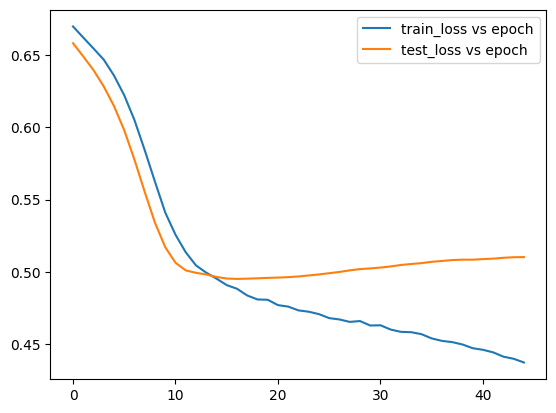

In [7]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()